In [1]:
from copy import deepcopy
import os
from unicodedata import decimal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# add imports for randomness
import time
import random

import sys

# Brevitas imports
import brevitas.nn as qnn
from brevitas.core.quant import QuantType
from brevitas.quant import Int32Bias
import torch.nn.functional as F

# For adaptive learning rate import
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split


## Imports from utils file for my defined noise functions
import sys
sys.path.append('C:/Users/ashin/source/repos/Cifar10_Pytorch_NoiseAnalysis/Cifar10_Pytorch_NoiseAnalysis/pynq-finn-FPGA/noise_weight_analysis/utils/')

from noise_functions import random_clust_mask, add_mask_to_model_brevitas, mask_noise_plots_brevitas, add_digital_noise, add_digital_noise_to_model_brevitas, ber_noise_plot_brevitas, add_gaussian_noise_to_model_brevitas, gaussian_noise_plots_brevitas, test
from noise_functions import add_gaussian_noise_independent, add_gaussian_noise_proportional

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cuda


In [3]:
from torchvision import transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply data augmentation to the training dataset
train_set = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=train_transform)

# Use the validation transform for the validation dataset
val_set =torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=val_transform)

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)


a = next(iter(train_loader))
print(a[0].size())
print(len(train_set))

print("Samples in each set: train = %d, test = %s" % (len(train_set), len(train_loader))) 
print("Shape of one input sample: " +  str(train_set[0][0].shape))

## Data Loader
#
# Using PyTorch dataloader we can create a convenient iterator over the dataset that returns batches of data, rather than requiring manual batch creation.

# set batch size
batch_size = 1000

# Create a DataLoader for a training dataset with a batch size of 1000
train_quantized_loader = DataLoader(train_set, batch_size=batch_size)
test_quantized_loader = DataLoader(val_set, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])
50000
Samples in each set: train = 50000, test = 391
Shape of one input sample: torch.Size([3, 32, 32])


In [4]:
count = 0

print("\nDataset Shape:\n-------------------------")
for x, y in train_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break



Dataset Shape:
-------------------------
Input shape for 1 batch: torch.Size([128, 3, 32, 32])
Label shape for 1 batch: torch.Size([128])


In [5]:
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=4, return_quant_tensor=True)

        self.layer1 = qnn.QuantConv2d(3, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer2 = qnn.QuantConv2d(32, 32, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer3 = qnn.QuantConv2d(32, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu3 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer4 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu4 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.layer5 = qnn.QuantConv2d(64, 64, 3, padding=1, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu5 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc1 = qnn.QuantLinear(64 * 8 * 8, 512, bias=True, weight_bit_width=4, bias_quant=Int32Bias)
        self.relu6 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)

        self.fc2 = qnn.QuantLinear(512, 10, bias=True, weight_bit_width=4, bias_quant=Int32Bias)

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = F.max_pool2d(x, 2)

        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x))
        x = F.max_pool2d(x, 2)

        x = self.relu5(self.layer5(x))

        x = x.view(x.size(0), -1)

        x = self.relu6(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
# Import testing
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import precision_recall_fscore_support

# Initialize the model, optimizer, and criterion
model = CIFAR10CNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()

num_epochs = 80
best_test_accuracy = 0
patience = 8
no_improvement_counter = 0

In [ ]:
for epoch in range(num_epochs):

    # training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    # Initialize the validation loss
    val_loss = 0
    
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()  # accumulate the validation loss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
        val_loss /= len(val_loader)  # calculate the average validation loss
    
        # Update the learning rate using the validation loss
        scheduler.step(val_loss)

        test_accuracy = 100 * correct / total
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
            
        if no_improvement_counter >= patience:
            print("Early stopping")
            break

        print('Epoch [{}/{}], Test Accuracy: {:.2f}%, Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}'.format(epoch+1, num_epochs, test_accuracy, precision, recall, f1))


In [ ]:
# Print the best test accuracy
print("The final best test accuracy is: {:.2f}%".format(best_test_accuracy))

In [ ]:
trained_state_dict = model.state_dict()

## Saving Model

In [ ]:
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_test_accuracy': best_test_accuracy,
        'epoch': epoch
        }, 'best_model.pth')
    no_improvement_counter = 0


In [7]:
# Create an instance of your neural network model
model = CIFAR10CNN().to(device)

# Load the saved state dictionary from file
state_dict = torch.load('best_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)


<All keys matched successfully>

In [8]:
print(model.layer1.weight.shape)
print(model.layer2.weight.shape)
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([512, 4096])
torch.Size([10, 512])


## Plots

## Mask Code Here for Editing

In [11]:
def random_clust_mask(weight, P, gamma):

    # Generate random NxN matrix with values between 0 and 1
    N = weight.shape[0]
    M = weight.shape[1]
    
    weight_numpy = weight.cpu().numpy()
    
    if (N  > M):
        
        matrix = np.random.rand(N, N)
        L = N
        
    else:
        
        matrix = np.random.rand(M, M)
        L = M
    
            
    matrix_tensor = torch.tensor(matrix)
    
    # Compute 2D FFT
    fft_result = np.fft.fft2(matrix)

    # 1D Frequency Vector with N bins
    f = np.fft.fftfreq(L, d=1.0/L)
    f_x, f_y = np.meshgrid(f, f)
    f_x[0] = 1e-6
    f_y[0] = 1e-6

    # Create a 2D filter in frequency space that varies inversely with freq over f
    # Gamma controls the falloff rate
    filter_2D = 1/(np.sqrt(f_x**2 + f_y**2))**gamma

    # Mult the 2D elementwise by the filter
    filtered_fft = fft_result * filter_2D

    # 2D inverse FFT of the filtered result
    ifft_result = np.fft.ifft2(filtered_fft)
    ifft_result = np.real(ifft_result)

    # Set the threshold T equal the the max value in IFFT
    T = ifft_result.max()

    # Init empty bool mask with same dims as ifft
    mask = np.zeros_like(ifft_result, dtype=bool)

    decrement_step = 0.01

    # Repeat until frac of nonzero values in the mask is greater than or equal to P
    while True:
        mask = ifft_result > T

        current_fraction = np.count_nonzero(mask) / (N * N)

        if current_fraction >= P:
            break

        T -= decrement_step

    # Return tensor with the same shape as the input tensor
    # mask = np.tile(mask, (weight_shape[0], weight_shape[1], 1, 1))
    
    if (N > M):
        
        mask = mask[:,:M]
        
    else:
        
        mask = mask[:N,:]
        
    mask_final = np.zeros_like(weight_numpy)
    #print(mask_final.shape)
    #print(mask.shape)
    
    mask_tensor = torch.tensor(mask, dtype=torch.bool, device=weight.device)
    mask_final = torch.zeros_like(weight)
    # Create a temporary tensor that repeats the mask tensor along the 3rd dimension
    temp_mask = mask_tensor.unsqueeze(2).repeat(1, 1, weight.shape[2])

    # Copy the temporary mask tensor along the 4th dimension (axis=3) of the mask_final tensor
    for i in range(mask_final.shape[3]):
        mask_final[:, :, :, i] = temp_mask
        
    mask_logical = torch.zeros(weight.shape, dtype=torch.bool,device=weight.device)
    mask_logical = (mask_final==1)
    mask_numeric = mask_final
    
    #mask tensor is 2D and float type
    #mask numeric/final is 4D and float like
    #mask logical is 4D and bool type
    return mask_tensor, mask_numeric, mask_logical




def return_noisy_matrix(independent, dim_matrix, sigma):
    
    if (independent):
        noised_matrix = torch.randn(dim_matrix) * sigma
    else:
        noised_matrix = torch.randn(dim_matrix) * sigma + 1

    return noised_matrix.to(device)

"""
This function takes a brevitas layer, a mask generated by the random_clust_mask function,
and two parameters P and gamma. It generates a random clustered mask using the random_clust_mask
function, and then sets the weights at the locations in the mask to zero, effectively sparsifying
the layer's weights.
"""

def add_mask_to_model_brevitas(model, layer_names, p, gamma, num_perturbations, sigma, independent_type, print_weights=False):

    modified_models = []

    for _ in range(num_perturbations):

        modified_model = deepcopy(model)

        for layer_name in layer_names:

            layer = getattr(modified_model, layer_name)

            with torch.no_grad():

                # get weights of the tensors
                weight_tensor = layer.weight.clone().detach()
                
                #print(weight_tensor.shape)
                
                # generate mask with correct shape
                mask_graph, mask_numeric, mask_logical = random_clust_mask(weight_tensor, p, gamma)
                

                if print_weights:
                    print("Weights before masking:")
                    print(weight_tensor)
                    
                #plt.imshow(weight_tensor.cpu().numpy(), cmap='viridis', aspect = 'auto')
                #plt.colorbar()
                #plt.show()
                #plt.clf()

                # apply mask to the whole weight tensor
                #print("mask logical = ",mask_logical)
                #print("mask numeric = ",mask_numeric)
                
                #height, width = mask_graph.shape
                #                
                #plt.imshow(mask_graph.cpu().numpy(), cmap='viridis', aspect='auto', extent=[0, width - 1, 0, height - 1])
                #plt.colorbar()
                #plt.title("Mask Graph")
                #plt.show()
                #plt.clf()
                
                if (independent_type):
                    weight_tensor += mask_numeric * return_noisy_matrix(independent_type, weight_tensor.shape, sigma)
                else:
                    noisy_mat = return_noisy_matrix(independent_type, weight_tensor.shape, sigma)
                    noisy_mat[~mask_logical] =  1
                    weight_tensor *= noisy_mat
                
                if print_weights:
                    print("Weights after masking:")
                    print(weight_tensor)
                    
                #plt.imshow(weight_tensor.cpu().numpy(), cmap='viridis', aspect = 'auto')
                #plt.colorbar()
                #plt.show()
                #plt.clf()

                # create new weight parameter and assign to layer
                noised_weight = torch.nn.Parameter(weight_tensor, requires_grad=False)
                
                
                layer.weight = noised_weight

        modified_models.append(modified_model)

    return modified_models

"""
The function mask_noise_plots_brevitas() is a Python function that is used to visualize the effect of different perturbations on the accuracy of a neural network. 
It generates several visualizations, including a heatmap and a scatter plot.

The function takes in the following parameters:

    num_perturbations: an integer indicating the number of perturbations to apply to the neural network
    layer_names: a list of strings indicating the names of the layers in the neural network
    p_vals: a list of floats indicating the p values to use for the mask perturbation
    gamma_vals: a list of floats indicating the gamma values to use for the mask perturbation
    model: the neural network model to test
    device: the device to use for testing the model

The function begins by creating a directory for saving the output plots. 
It then initializes an empty list called all_test_accs to store the test accuracies for each layer.

For each layer in layer_names, the function initializes an empty list called test_accs to store 
the test accuracies for each mask perturbation. The function then iterates over each p and gamma value 
and adds noise to the model for the defined layer only. It then tests the accuracy of each noisy model 
and appends the result to the accuracies list. The function then calculates the average accuracy 
and prints the result.

The test accuracies for the current layer are then stored in the all_test_accs list.

The function then creates a heatmap for each layer and saves it to disk.
It also computes the average test accuracy across all layers for each p and gamma value and creates a
heatmap for the average test accuracy. Both the individual and average heatmaps have a color bar 
indicating the test accuracy.

Finally, the function creates a scatter plot showing the test accuracies for each layer at each p 
and gamma value. The plot has layer_names on the x-axis, p_vals on the y-axis, and gamma_vals on the z-axis. 
The points in the plot are colored based on the corresponding test accuracy, with a color bar indicating 
the mapping between color and test accuracy.
"""

def test(model, test_loader, device):
    # testing phase
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def mask_noise_plots_brevitas(num_perturbations, layer_names, p_values, gamma_values, model, device, sigma_values, independent_type):
    
    # Check if output directory exists, if not, create it
    if (independent_type):
        if not os.path.exists("noise_plots_brevitas/mask/line_plot/independent"):
            os.makedirs("noise_plots_brevitas/mask/line_plot/independent")
            
        output_dir = "noise_plots_brevitas/mask/line_plot/independent"
    else:
        if not os.path.exists("noise_plots_brevitas/mask/line_plot/proportional"):
            os.makedirs("noise_plots_brevitas/mask/line_plot/proportional")
            
        output_dir = "noise_plots_brevitas/mask/line_plot/proportional"

    for layer in layer_names:
        # Initialize a 3D array to store average accuracies for each combination of p, gamma, and sigma values
        avg_accuracies = np.zeros((len(p_values), len(gamma_values), len(sigma_values)))

        for p in range(len(p_values)):
            for g in range(len(gamma_values)):
                for s in range(len(sigma_values)):
                    noisy_models = add_mask_to_model_brevitas(model, [layer], p_values[p], gamma_values[g], num_perturbations, sigma_values[s], independent_type)

                    accuracies = []

                    for noisy_model in noisy_models:
                        noisy_model.to(device)
                        accuracies.append(test(noisy_model, test_quantized_loader, device))

                    avg_accuracy = sum(accuracies) / len(accuracies)
                    avg_accuracies[p, g, s] = avg_accuracy
                    print("Layer: {}\tP Value: {}\t Gamma Value: {}\t Sigma Value: {}\t Average Accuracy: {}%".format(layer, p_values[p], gamma_values[g], sigma_values[s], avg_accuracy))

        for p in range(len(p_values)):
            plt.figure()
        
            # Use different colors for each gamma value
            color_map = plt.get_cmap('viridis')
            colors = color_map(np.linspace(0, 1, len(gamma_values)))
        
            for g in range(len(gamma_values)):
                avg_accuracy_gamma = avg_accuracies[p, g, :]
                gamma_truncated = round(gamma_values[g], 3)
                plt.plot(sigma_values, avg_accuracy_gamma, color=colors[g], label=f'Gamma: {gamma_truncated}')

            plt.xlabel('Sigma Value')
            plt.ylabel('Average Accuracy')
            plt.title(f'Line Plot for P Value: {p_values[p]}')
            plt.legend(title='Gamma Values')
            plt.savefig(os.path.join(output_dir, f'line_plot_p_{p_values[p]}_{layer}.png'))
            plt.clf()


def mask_noise_plots_brevitas_multiple_layers(num_perturbations, layer_names_list, p_values, gamma_values, model, device, sigma_values, independent_type):
    if (independent_type):
        if not os.path.exists("noise_plots_brevitas/mask/line_plot/independent"):
            os.makedirs("noise_plots_brevitas/mask/line_plot/independent")
            
        output_dir = "noise_plots_brevitas/mask/line_plot/independent"
    else:
        if not os.path.exists("noise_plots_brevitas/mask/line_plot/proportional"):
            os.makedirs("noise_plots_brevitas/mask/line_plot/proportional")
            
        output_dir = "noise_plots_brevitas/mask/line_plot/proportional"

    for layer_names in layer_names_list:
        layer_combo_name = '_'.join(layer_names)
        avg_accuracies = np.zeros((len(p_values), len(gamma_values), len(sigma_values)))

        for p in range(len(p_values)):
            for g in range(len(gamma_values)):
                for s in range(len(sigma_values)):
                    noisy_models = add_mask_to_model_brevitas(model, layer_names, p_values[p], gamma_values[g], num_perturbations, sigma_values[s], independent_type)

                    accuracies = []

                    for noisy_model in noisy_models:
                        noisy_model.to(device)
                        accuracies.append(test(noisy_model, test_quantized_loader, device))

                    avg_accuracy = sum(accuracies) / len(accuracies)
                    avg_accuracies[p, g, s] = avg_accuracy
                    print("Layers: {}\tP Value: {}\t Gamma Value: {}\t Sigma Value: {}\t Average Accuracy: {}%".format(layer_combo_name, p_values[p], gamma_values[g], sigma_values[s], avg_accuracy))

        for p in range(len(p_values)):
            plt.figure()
        
            color_map = plt.get_cmap('viridis')
            colors = color_map(np.linspace(0, 1, len(gamma_values)))
        
            for g in range(len(gamma_values)):
                avg_accuracy_gamma = avg_accuracies[p, g, :]
                gamma_truncated = round(gamma_values[g], 3)
                plt.plot(sigma_values, avg_accuracy_gamma, color=colors[g], label=f'Gamma: {gamma_truncated}')

            plt.xlabel('Sigma Value')
            plt.ylabel('Average Accuracy')
            plt.title(f'Line Plot for P Value: {p_values[p]}')
            plt.legend(title='Gamma Values')
            plt.savefig(os.path.join(output_dir, f'line_plot_p_{p_values[p]}_{layer_combo_name}.png'))
            plt.clf()


In [12]:
## Mask
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5']
layer_combinations = [['layer1', 'layer2', 'layer3', 'layer4', 'layer5']]

perturbations = 3
p_values = [1, 0.5, 0.25]
gamma_values = np.linspace(0.001, 0.1, 5)
sigma = np.linspace(0.0, 0.2, 10)

#mask_noise_plots_brevitas(perturbations, layer_names, p_values, gamma_values, model, device, sigma, 1)
mask_noise_plots_brevitas(perturbations, layer_names, p_values, gamma_values, model, device, sigma, 0)

mask_noise_plots_brevitas_multiple_layers(perturbations, layer_combinations, p_values, gamma_values, model, device, sigma, 1)
mask_noise_plots_brevitas_multiple_layers(perturbations, layer_combinations, p_values, gamma_values, model, device, sigma, 0)


Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.43%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.46999999999998%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.32000000000001%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.18333333333332%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.01666666666667%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.23%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.15555555555555556	 Average Accuracy: 84.62333333333333%
Layer: layer1	P Value: 1	 Gamma Value: 0.001	 Sigma Value: 0.17777777777777778	 Average Accuracy: 84.0433333333333

Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.41333333333334%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.49000000000001%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.49666666666667%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.35333333333334%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.26666666666667%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.11666666666667%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.15555555555555556	 Average Accuracy: 84.79%
Layer: layer1	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.17777777777777

Layer: layer1	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.2	 Average Accuracy: 85.27%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.58333333333333%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.43333333333334%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.37333333333333%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.28666666666668%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.31666666666666%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.25666666666667%
Layer: layer1	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.15555555555555556	 Average Accur

Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.56333333333333%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.53666666666668%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.50333333333333%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.33%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.34333333333332%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.36%
Layer: layer2	P Value: 0.5	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.15555555555555556	 Average Accurac

Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.45%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.59666666666665%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.5%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.39666666666666%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.47333333333331%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.43666666666667%
Layer: layer2	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.15555555555555556	 Average Accuracy

Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.65666666666668%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.58999999999999%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.79666666666667%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.57000000000001%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.58999999999999%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.59666666666668%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.15555555555555556	 Average Accuracy: 85.65666666666665%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001	 Sigma Value: 0.17777777777777778	 Average Accuracy: 85.55333333333334%
Layer: layer3	P Value: 0.5	 Gamma Value: 0.001

Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.78333333333332%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.77%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.83333333333333%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.56%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.48333333333333%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.52999999999999%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.15555555555555556	 Average Accuracy: 85.43666666666667%
Layer: layer3	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.17777777777777778

Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.64333333333333%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.75%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.65000000000002%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.65333333333335%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.61%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.40666666666668%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.15555555555555556	 Average Accuracy: 85.37333333333333%
Layer: layer4	P Value: 1	 Gamma Value: 0.1	 Sigma Value: 0.17777777777777778	 Average Accuracy: 85.61666666666667%
Layer: layer4	P

Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.78333333333332%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.72333333333334%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.67666666666666%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.67333333333333%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.74666666666667%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.63%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.15555555555555556	 Average Accuracy: 85.62666666666667%
Layer: layer4	P Value: 0.25	 Gamma Value: 0.025750000000000002	 S

Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.65333333333332%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.58333333333333%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.41333333333334%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.5%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.42999999999999%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.51666666666667%
Layer: layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.15555555555555556	 Average Accuracy: 85.0066666

Layer: layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.2	 Average Accuracy: 85.35333333333334%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.58%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 85.55666666666667%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.06666666666666667	 Average Accuracy: 85.41000000000001%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 85.40333333333332%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 85.51666666666667%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 85.49666666666667%
Layer: layer5	P Value: 0.25	 Gamma Value: 0.001	 Sigma Value: 0.15555555555555556	 Average Accura

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.11111111111111112	 Average Accuracy: 19.673333333333332%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.13333333333333333	 Average Accuracy: 14.063333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.15555555555555556	 Average Accuracy: 11.92%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.17777777777777778	 Average Accuracy: 11.903333333333334%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.025750000000000002	 Sigma Value: 0.2	 Average Accuracy: 10.336666666666666%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.0505	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.0505	 Sigma Value: 0.022222222

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.022222222222222223	 Average Accuracy: 83.7%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.044444444444444446	 Average Accuracy: 79.66666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.06666666666666667	 Average Accuracy: 68.28666666666666%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.08888888888888889	 Average Accuracy: 58.06666666666666%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.11111111111111112	 Average Accuracy: 46.046666666666674%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.13333333333333333	 Average Accuracy: 22.680000000000003%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.0505	 Sigma Value: 0.15555555555555556	 Ave

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.15555555555555556	 Average Accuracy: 44.9%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.17777777777777778	 Average Accuracy: 29.253333333333334%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.0505	 Sigma Value: 0.2	 Average Accuracy: 21.563333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.022222222222222223	 Average Accuracy: 84.72666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.044444444444444446	 Average Accuracy: 81.46%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.06666666666666667	 

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.08888888888888889	 Average Accuracy: 84.71333333333332%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.11111111111111112	 Average Accuracy: 83.42333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.13333333333333333	 Average Accuracy: 83.61%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.15555555555555556	 Average Accuracy: 82.91666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.17777777777777778	 Average Accuracy: 82.37666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 0.07525000000000001	 Sigma Value: 0.2	 Average Accuracy: 80.23333333333335%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 1	 Gamma Value: 

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.0	 Average Accuracy: 85.88%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.022222222222222223	 Average Accuracy: 85.04%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.044444444444444446	 Average Accuracy: 84.74333333333334%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.06666666666666667	 Average Accuracy: 84.76666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.08888888888888889	 Average Accuracy: 84.55666666666667%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.11111111111111112	 Average Accuracy: 84.33333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.5	 Gamma Value: 0.1	 Sigma Value: 0.13333333333333333	 Average Accuracy: 84.40333333333334%
Layers: layer1_l

Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.13333333333333333	 Average Accuracy: 83.89333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.15555555555555556	 Average Accuracy: 84.44333333333333%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.17777777777777778	 Average Accuracy: 84.05%
Layers: layer1_layer2_layer3_layer4_layer5	P Value: 0.25	 Gamma Value: 0.1	 Sigma Value: 0.2	 Average Accuracy: 83.45333333333333%


C:\Users\ashin\AppData\Local\Temp\ipykernel_28220\3123185787.py:319: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
def add_digital_noise_to_model_brevitas(model, layer_names, ber, num_perturbations):
    
    modified_models = []
    
    for _ in range(num_perturbations):
        
        modified_model = deepcopy(model)
        
        for layer_name in layer_names:
            
            layer = getattr(modified_model, layer_name)
            
            with torch.no_grad():
                
                weight = layer.weight.cpu().detach().numpy()
                noisy_weight = add_digital_noise(weight, ber)
                
                
                layer.weight = torch.nn.Parameter(torch.tensor(noisy_weight, dtype=torch.float))
                
        modified_models.append(modified_model)
        
    return modified_models

def ber_noise_plot_brevitas(num_perturbations, layer_names, ber_vector, model, device, test_quantized_loader):
    
    if not os.path.exists("noise_plots_brevitas/ber_noise/"):
        os.makedirs("noise_plots_brevitas/ber_noise/")
    
    plt.style.use('default')
    
    all_test_accs = []

    for layer in layer_names:
        test_accs = []
        
        for ber in ber_vector:
            noisy_models = add_digital_noise_to_model_brevitas(model, [layer], ber, num_perturbations)
            
            accuracies = []
            
            for noisy_model in noisy_models:
                
                noisy_model.to(device)
                accuracies.append(test(noisy_model, test_quantized_loader, device))
                
            avg_accuracy = sum(accuracies) / len(accuracies)
            
            test_accs.append(avg_accuracy)
            
            print("BER Value: {}\tAverage Accuracy: {}".format(ber, avg_accuracy))
            
        all_test_accs.append(test_accs)
        
        plt.plot(ber_vector, test_accs,
                 label='{} Accuracy at Different Perturbation Levels'.format(layer))

    avg_test_accs = [sum(x) / len(x) for x in zip(*all_test_accs)]

    plt.plot(ber_vector, avg_test_accs, label='Average',
             linewidth=3, linestyle='--', color="black")

    plt.xlabel('BER Value')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of BER Noise on Test Accuracy (Individual Layers and Average)')
    plt.legend(title='Layers')
    plt.savefig("noise_plots_brevitas/ber_noise/individual_and_average.png")
    plt.show()
    plt.clf()

    
def ber_noise_plot_brevitas_multiple_layers(num_perturbations, layer_names, ber_vector, model, device, test_quantized_loader):
    
    if not os.path.exists("noise_plots_brevitas/ber_noise/"):
        os.makedirs("noise_plots_brevitas/ber_noise/")
    
    plt.style.use('default')
    
    test_accs = []

    for ber in ber_vector:
        noisy_models = add_digital_noise_to_model_brevitas(model, layer_names, ber, num_perturbations)
        
        accuracies = []
        
        for noisy_model in noisy_models:
            
            noisy_model.to(device)
            accuracies.append(test(noisy_model, test_quantized_loader, device))
            
        avg_accuracy = sum(accuracies) / len(accuracies)
        
        test_accs.append(avg_accuracy)
        
        print("BER Value: {}\tAverage Accuracy: {}".format(ber, avg_accuracy))
            
    plt.plot(ber_vector, test_accs, label='Accuracy at Different Perturbation Levels')

    plt.xlabel('BER Value')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of BER Noise on Test Accuracy (All Layers)')
    plt.legend(title='Layers')
    plt.savefig("noise_plots_brevitas/ber_noise/all_layers.png")
    plt.show()
    plt.clf()


BER Value: 1e-05	Average Accuracy: 85.41
BER Value: 0.0007235714285714287	Average Accuracy: 75.21
BER Value: 0.0014371428571428573	Average Accuracy: 80.41
BER Value: 0.0021507142857142857	Average Accuracy: 71.85
BER Value: 0.0028642857142857146	Average Accuracy: 66.94
BER Value: 0.0035778571428571435	Average Accuracy: 55.69
BER Value: 0.004291428571428571	Average Accuracy: 53.91
BER Value: 0.005005	Average Accuracy: 59.35
BER Value: 0.005718571428571429	Average Accuracy: 52.43
BER Value: 0.006432142857142858	Average Accuracy: 59.17
BER Value: 0.0071457142857142865	Average Accuracy: 47.98
BER Value: 0.007859285714285714	Average Accuracy: 52.55
BER Value: 0.008572857142857142	Average Accuracy: 57.12
BER Value: 0.009286428571428572	Average Accuracy: 55.29
BER Value: 0.01	Average Accuracy: 49.56


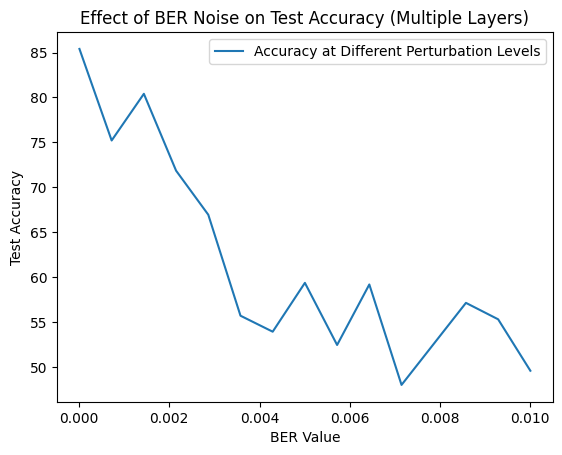

<Figure size 640x480 with 0 Axes>

In [18]:
## Digital Noise with BER
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'fc1', 'fc2']

ber_vals = np.linspace(1e-5, 0.01, 15)
perturbations = 1

ber_noise_plot_brevitas(perturbations, layer_names, ber_vals, model, device, test_quantized_loader)
ber_noise_plot_brevitas_multiple_layers(perturbations, layer_names, ber_vals, model, device, test_quantized_loader)

Proportional: Sigma Value: 0.0, Average Accuracy: 85.88%
Proportional: Sigma Value: 0.0035714285714285718, Average Accuracy: 85.725%
Proportional: Sigma Value: 0.0071428571428571435, Average Accuracy: 85.685%
Proportional: Sigma Value: 0.010714285714285714, Average Accuracy: 85.81%
Proportional: Sigma Value: 0.014285714285714287, Average Accuracy: 85.815%
Proportional: Sigma Value: 0.01785714285714286, Average Accuracy: 85.63%
Proportional: Sigma Value: 0.02142857142857143, Average Accuracy: 85.855%
Proportional: Sigma Value: 0.025, Average Accuracy: 85.58500000000001%
Proportional: Sigma Value: 0.028571428571428574, Average Accuracy: 85.65%
Proportional: Sigma Value: 0.03214285714285715, Average Accuracy: 85.58500000000001%
Proportional: Sigma Value: 0.03571428571428572, Average Accuracy: 85.67%
Proportional: Sigma Value: 0.03928571428571429, Average Accuracy: 85.71000000000001%
Proportional: Sigma Value: 0.04285714285714286, Average Accuracy: 85.495%
Proportional: Sigma Value: 0.0464

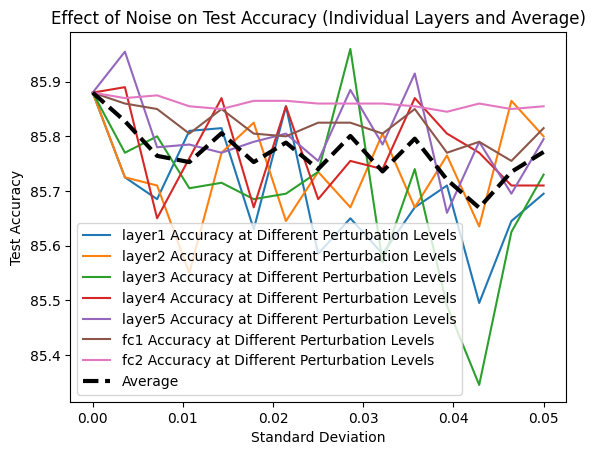

Independent: Sigma Value: 0.0, Average Accuracy: 85.88%
Independent: Sigma Value: 0.0035714285714285718, Average Accuracy: 85.25%
Independent: Sigma Value: 0.0071428571428571435, Average Accuracy: 83.945%
Independent: Sigma Value: 0.010714285714285714, Average Accuracy: 69.625%
Independent: Sigma Value: 0.014285714285714287, Average Accuracy: 76.055%
Independent: Sigma Value: 0.01785714285714286, Average Accuracy: 83.02000000000001%
Independent: Sigma Value: 0.02142857142857143, Average Accuracy: 85.58000000000001%
Independent: Sigma Value: 0.025, Average Accuracy: 68.135%
Independent: Sigma Value: 0.028571428571428574, Average Accuracy: 70.38%
Independent: Sigma Value: 0.03214285714285715, Average Accuracy: 38.775%
Independent: Sigma Value: 0.03571428571428572, Average Accuracy: 56.435%


In [ ]:
## Gaussian Noise
sigma_vector = np.linspace(0, 0.05, 15)

gaussian_noise_plots_brevitas(2, layer_names, sigma_vector, model, device, test_quantized_loader, 0)
gaussian_noise_plots_brevitas(2, layer_names, sigma_vector, model, device, test_quantized_loader, 1)

In [ ]:
fc2_weights = model.fc2.weight
fc1_weights = model.fc1.weight

flattened_fc2 = fc2_weights.view(-1).cpu().detach().numpy()
flattened_fc1 = fc1_weights.view(-1).cpu().detach().numpy()

plt.hist(flattened_fc1, bins = 150)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('fc1')
plt.show()
plt.clf()

plt.hist(flattened_fc2, bins = 150)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('fc2')
plt.show()